In [ ]:
import pandas as pd
import math
import datetime
from fastai.tabular import *
from fastai.imports import *
from fastai.metrics import error_rate
from fastai.callbacks import *
from sklearn.model_selection import train_test_split

In [ ]:
# Connecting to Google Drive where the data is present

from google.colab import drive

# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/Fifa20/'

In [ ]:
players_df = pd.read_csv(path+'players_20.csv')
players_df

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,https://sofifa.com/player/245006/shuai-shao/20...,Shao Shuai,邵帅,22,1997-03-10,186,79,China PR,Beijing Renhe FC,48,56,40000,2000,CB,Right,1,3,2,Medium/High,Normal,No,70000.0,NaN,RES,36.0,NaN,2018-07-13,2019.0,NaN,NaN,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,...,46,48,28,25,39,41,45,50,52,5,5,13,5,14,

In [ ]:
players_df['value_eur'] = players_df['value_eur'].apply(lambda x : 1 if x == 0 else x)

In [ ]:

players_df['loaned_status'] = players_df['loaned_from'].fillna('').apply(lambda x:'no' if x == '' else 'yes')


In [ ]:
curr_year = 2019
players_df['contart_expiry_in'] = players_df['contract_valid_until'].apply(lambda x : x-curr_year)
players_df

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,loaned_status,contart_expiry_in
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2,no,2.0
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,no,3.0
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3,no,3.0
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,4.0
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3,no,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,245006,https://sofifa.com/player/245006/shuai-shao/20...,Shao Shuai,邵帅,22,1997-03-10,186,79,China PR,Beijing Renhe FC,48,56,40000,2000,CB,Right,1,3,2,Medium/High,Normal,No,70000.0,NaN,RES,36.0,NaN,2018-07-13,2019.0,NaN,NaN,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,...,28,25,39,41,45,50,52,5,5,13,5,14,32+2,32+2,32+2

In [ ]:
cont_var = ['age','height_cm','weight_kg','overall','potential','wage_eur','international_reputation','weak_foot','skill_moves','release_clause_eur',
            'pace','shooting','passing','dribbling','defending','physic','gk_diving','gk_handling','gk_kicking','gk_reflexes','gk_speed','gk_positioning',
            'attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys',
            'skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed',
            'movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots',
            'mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure', 
            'defending_marking','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking',
            'goalkeeping_positioning','goalkeeping_reflexes','contart_expiry_in']

In [ ]:
cat_var = ['preferred_foot','work_rate','body_type','team_position','nation_position','loaned_status','player_traits']

In [ ]:
procs = [FillMissing, Categorify, Normalize]

In [ ]:
dep_var = 'value_eur'
players_df = players_df[cat_var + cont_var + [dep_var]].copy()

In [ ]:
players_df

,preferred_foot,work_rate,body_type,team_position,nation_position,loaned_status,player_traits,age,height_cm,weight_kg,overall,potential,wage_eur,international_reputation,weak_foot,skill_moves,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,contart_expiry_in,value_eur
0,Left,Medium/Low,Messi,RW,NaN,no,"Beat Offside Trap, Argues with Officials, Earl...",32,170,72,94,94,565000,5,4,4,195800000.0,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,2.0,95500000
1,Right,High/Low,C. Ronaldo,LW,LS,no,"Long Throw-in, Selfish, Argues with Officials,...",34,187,83,93,93,405000,5,4,5,96500000.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,3.0,58500000
2,Right,High/Medium,Neymar,CAM,LW,no,"Power Free-Kick, Injury Free, Selfish, Early C...",27,175,68,92,92,290000,5,5,5,195200000.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,3.0,105500000
3,Right,Medium/Medium,Normal,GK,GK,no,"Flair, Acrobatic Clearance",26,188,87,91,93,125000,3,3,1,164700000.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,4.0,77500000
4,Right,High/Medium,Normal,LW,LF,no,"Beat Offside Trap, Selfish, Finesse Shot, Spee...",28,175,74,91,91,470000,4,4,4,184500000.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,5.0,90000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,Right,Medium/High,Normal,RES,NaN,no,NaN,22,186,79,48,56,2000,1,3,2,70000.0,57.0,23.0,28.0,33.0,47.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,21,17,40,35,27,24,23,21,28,35,56,58,45,40,73,36,70,60,47,16,46,48,28,25,39,41,45,50,52,5,5,13,5,14,0.0,40000
18274,Right,Medium/Medium,Normal,SUB,NaN,no,NaN,22,177,66,48,56,2000,1,2,2,72000.0,58.0,24.0,33.0,35.0,48.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,24,20,42,43,28,32,24,29,39,31,55,61,43,41,76,33,72,55,44,20,42,49,23,25,37,35,42,53,57,13,6,14,11,9,3.0,40000
18275,Right,Low/Medium,Lean,SUB,NaN,no,NaN,19,186,75,48,56,1000,1,2,2,70000.0,54.0,35.0,44.0,45.0,48.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,32,33,49,53,32,40,32,32,55,49,55,54,52,52,57,48,60,50,51,26,50,45,38,38,36,39,46,52,46,7,8,10,6,14,0.0,40000
18276,Right,Low/Low,Lean,SUB,NaN,no,NaN,18,185,74,48,54,1000,1,2,2,70000.0,59.0,35.0,47.0,47.0,45.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,39,34,47,54,28,42,37,39,48,49,55,63,55,54,59,46,61,42,55,28,57,49,31,48,36,40,39,44,54,14,9,13,13,13,3.0,40000


In [ ]:
players_df_train, players_df_test = train_test_split(players_df, test_size = 0.2, random_state = 0)
players_df_train.shape,players_df_test.shape

((14622, 65), (3656, 65))

In [ ]:
valid_idx = range(len(players_df_train)-10000, len(players_df_train)-8000)

In [ ]:
# Test tabularlist
test = TabularList.from_df(players_df_test, cat_names=cat_var, cont_names=cont_var, procs=procs)

In [35]:
# Train data bunch
data = (TabularList.from_df(players_df_train, path='.', cat_names=cat_var, cont_names=cont_var, procs=procs)
                        .split_by_rand_pct(valid_pct = 0.1, seed = 42)
                        .label_from_df(cols = dep_var, label_cls = FloatList, log = True )
                        .add_test(test)
                        .databunch())

In [36]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[ 2  9  5 22 ...  1  1  1  1]
 [ 2  7  5 18 ...  2  2  2  1]
 [ 2  3  7 28 ...  2  2  2  1]
 [ 2  9  5 22 ...  2  2  2  1]
 [ 2  7  5 20 ...  2  2  2  1]]
[[-0.704127  1.860105  2.216898 -1.3411   ...  2.25679   2.061339  2.217141  0.683671]
 [-0.704127  0.536225 -0.179366 -0.187965 ... -0.076612 -0.606266 -0.263463 -0.875079]
 [-0.061466 -0.934753 -0.03841   0.244461 ... -0.256104 -0.316309 -0.428836  0.683671]
 [ 1.438076  0.683323  0.666374  0.388602 ... -0.315935 -0.432292 -0.318587 -0.875079]
 [-0.061466 -2.699926 -1.588933  0.532744 ... -0.076612 -0.142335 -0.428836 -0.875079]]
[11.77529  13.493927 13.910821 13.652991 14.557447]


In [37]:
# max_y = np.max(players_df_train['value_eur'])*1.2
# y_range = torch.tensor([0, max_y], device=defaults.device)
# y_range
# tensor([ 0.0000, 14.2363])

In [ ]:
learn = tabular_learner(data, layers=[200,100], metrics=rmse, ps=[0.001,0.01], emb_drop=0.01)

In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(10, 6)
    (2): Embedding(8, 5)
    (3): Embedding(30, 11)
    (4): Embedding(25, 10)
    (5): Embedding(3, 3)
    (6): Embedding(767, 66)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.01, inplace=False)
  (bn_cont): BatchNorm1d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=203, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=200

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


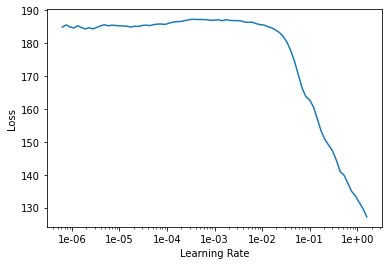

In [ ]:
# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot(suggetion=True)

In [ ]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,11.416712,0.810188,0.862225,00:03
1,0.889096,1.078513,1.025305,00:03
2,0.624969,0.511792,0.704274,00:03
3,0.593102,0.254429,0.497923,00:03
4,0.587337,0.734935,0.735153,00:03
5,0.510785,1.090462,1.041627,00:03
6,0.393761,0.367126,0.605706,00:03
7,0.252881,0.059677,0.241608,00:03
8,0.203303,0.036780,0.190807,00:03
9,0.142508,0.023939,0.147687,00:03


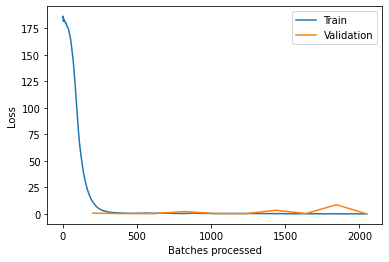

In [ ]:
learn.recorder.plot_losses()

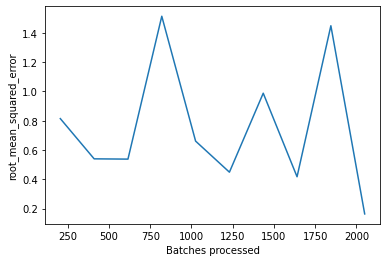

In [ ]:
learn.recorder.plot_losses()

In [30]:
# get predictions
preds, targets = learn.get_preds(DatasetType.Test)
labels = [np.exp(p[0].data.item()) for p in preds]

In [55]:
test_preds = pd.DataFrame({'test_val': list(players_df_test['value_eur']), 'test_val_pred': [str(x) for x in labels]})
test_preds

,test_val,test_val_pred
0,825000,832124.8004085232
1,290000,303272.4733458068
2,375000,381638.14134409593
3,975000,975303.0301954708
4,850000,1023068.4128402835
...,...,...
3651,200000,200950.23486792578
3652,14000000,12111357.85308102
3653,3900000,3718258.8287000414
3654,2200000,1888538.8116015638


In [31]:
learn.save('fifa20_stage_1.csv')

In [ ]:
test_preds.to_csv(path+'fifa_results.csv')

In [54]:
test_preds = pd.read_csv(path+'fifa_results.csv')
test_preds = test_preds[['test_val',	'test_val_pred']]
test_preds['test_val_pred'] = test_preds['test_val_pred'].astype(str)
test_preds

,test_val,test_val_pred
0,825000,832124.8004085232
1,290000,303272.4733458068
2,375000,381638.14134409593
3,975000,975303.0301954708
4,850000,1023068.4128402835
...,...,...
3651,200000,200950.23486792578
3652,14000000,12111357.85308102
3653,3900000,3718258.8287000414
3654,2200000,1888538.8116015638
